In [1]:
import sys
import os
import json
import tqdm
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torch.optim import Adam
from torchvision.io import read_image
import torcheval.metrics as metrics

In [190]:
args = {
    'modelfile':'autoencoder-1.pth',
    'trainingdir':'/home/guserbto@GU.GU.SE/wikiart/train',
    'mismatcheddir': '/home/guserbto@GU.GU.SE/ml2/a2/mismatched',
    'device': 'cuda:3',
    'epochs':20,
    'batch_size':32,
    
}

modelfile = args['modelfile']
trainingdir = args['trainingdir']
mismatcheddir = args['mismatcheddir']
device = args['device']
epochs = args['epochs']
batch_size = args['batch_size']

In [3]:
class WikiArtImage:
    def __init__(self, imgdir, label, filename):
        self.imgdir = imgdir
        self.label = label
        self.filename = filename
        self.image = None
        self.loaded = False

    def get(self):
        if not self.loaded:
            self.image = read_image(os.path.join(self.imgdir, self.label, self.filename)).float()
            self.image /= 255.0
            self.loaded = True

        return self.image

In [4]:
class WikiArtDataset(Dataset):
    def __init__(self, imgdir, device="cpu"):
        walking = os.walk(imgdir)
        filedict = {}
        indices = []
        classes = set()
        print("Gathering files for {}".format(imgdir))
        for item in walking:
            sys.stdout.write('.')
            arttype = os.path.basename(item[0])
            artfiles = item[2]
            for art in artfiles:
                filedict[art] = WikiArtImage(imgdir, arttype, art)
                indices.append(art)
                classes.add(arttype)
        print("...finished")
        self.filedict = filedict
        self.imgdir = imgdir
        self.indices = indices
        self.classes = list(classes)
        self.device = device
        
    def __len__(self):
        return len(self.filedict)

    def __getitem__(self, idx):
        imgname = self.indices[idx]
        imgobj = self.filedict[imgname]
        ilabel = self.classes.index(imgobj.label)
        image = imgobj.get().to(self.device)

        return image, ilabel

    def get_filename(self, idx):
        imgname = self.indices[idx]
        imgobj = self.filedict[imgname]
        ilabel = self.classes.index(imgobj.label)
        image = imgobj.get().to(self.device)

        return imgname


    def get_image_by_filename(self, filename):
        if filename not in self.filedict:
            raise ValueError(f"Filename '{filename}' not found in the dataset.")
        
        # Retrieve the image object and label
        imgobj = self.filedict[filename]
        ilabel = self.classes.index(imgobj.label)
        image = imgobj.get().to(self.device)

        return image, ilabel

In [170]:
class AutoEncoder(nn.Module):
    def __init__(self, num_classes=27):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

   
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(528, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

        self.num_classes=num_classes


    def embed_label(self, encoded_image, label): 
        # encoded_image size = [batch_size, 512, 13, 13]
        embedding = nn.Embedding(self.num_classes, 16).to(device)
        emb_label = embedding(label).to(device)                                             # label size: [batch_size, 16]
        emb_label = emb_label.unsqueeze(2).unsqueeze(3)                                     # label size: [batch_size, 16, 1, 1]
        emb_label = emb_label.expand(-1, -1, encoded_image.size(2), encoded_image.size(3)) # label size: [batch_size, 16, 13, 13]
        return emb_label
         
        
    def encode(self, image):
        return self.encoder(image)

    def decode(self, img_label_tensor):
        return self.decoder(img_label_tensor)

    def forward(self, image, label):
        encoded = self.encoder(image)
        embedded_label = self.embed_label(encoded, label)
        img_label_tensor = torch.cat((encoded, embedded_label), dim=1) # img_label size: [batch_size, 528, 13, 13]
        decoded = self.decoder(img_label_tensor)
        return decoded

In [53]:
traindataset = WikiArtDataset(trainingdir, device)

Gathering files for /home/guserbto@GU.GU.SE/wikiart/train
...............................finished


In [136]:
# TRAIN

def train(epochs=3, batch_size=32, modelfile=None, device="cpu"):
    train_loader = DataLoader(traindataset, batch_size=batch_size, shuffle=True)

    model = AutoEncoder().to(device)
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss().to(device)

    train_loss = []

    for epoch in range(epochs):
        print("Starting epoch {}".format(epoch))
        accumulate_loss = 0
        for batch_id, batch in enumerate(tqdm.tqdm(train_loader)):
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X, y)
            loss = criterion(output, X)
            loss.backward()
            accumulate_loss += loss
            optimizer.step()

        print("In epoch {}, epoch_loss = {}".format(epoch +1, accumulate_loss))

    if modelfile:
        torch.save(model.state_dict(), modelfile)

    return model

In [137]:
model = train(args["epochs"], args["batch_size"], modelfile=args["modelfile"], device=device)

Starting epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:33<00:00,  4.49it/s]


In epoch 1, epoch_loss = 10.547368049621582
Starting epoch 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:04<00:00,  6.47it/s]


In epoch 2, epoch_loss = 3.81656551361084
Starting epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:10<00:00,  5.96it/s]


In epoch 3, epoch_loss = 3.1714844703674316
Starting epoch 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:07<00:00,  6.20it/s]


In epoch 4, epoch_loss = 2.902360439300537
Starting epoch 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:07<00:00,  6.21it/s]


In epoch 5, epoch_loss = 2.624608039855957
Starting epoch 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:07<00:00,  6.21it/s]


In epoch 6, epoch_loss = 2.5010640621185303
Starting epoch 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:06<00:00,  6.24it/s]


In epoch 7, epoch_loss = 2.4075779914855957
Starting epoch 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:06<00:00,  6.24it/s]


In epoch 8, epoch_loss = 2.1374077796936035
Starting epoch 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:07<00:00,  6.21it/s]


In epoch 9, epoch_loss = 2.0049445629119873
Starting epoch 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:06<00:00,  6.27it/s]


In epoch 10, epoch_loss = 1.9248595237731934
Starting epoch 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:07<00:00,  6.21it/s]


In epoch 11, epoch_loss = 1.8813068866729736
Starting epoch 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:07<00:00,  6.21it/s]


In epoch 12, epoch_loss = 1.7856404781341553
Starting epoch 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:07<00:00,  6.21it/s]


In epoch 13, epoch_loss = 1.7491658926010132
Starting epoch 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:07<00:00,  6.21it/s]


In epoch 14, epoch_loss = 1.6877483129501343
Starting epoch 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:07<00:00,  6.21it/s]


In epoch 15, epoch_loss = 1.6218631267547607
Starting epoch 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:07<00:00,  6.21it/s]


In epoch 16, epoch_loss = 1.6231424808502197
Starting epoch 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:07<00:00,  6.21it/s]


In epoch 17, epoch_loss = 1.5649986267089844
Starting epoch 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:07<00:00,  6.21it/s]


In epoch 18, epoch_loss = 1.5496280193328857
Starting epoch 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:06<00:00,  6.28it/s]


In epoch 19, epoch_loss = 1.5013909339904785
Starting epoch 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [01:05<00:00,  6.37it/s]


In epoch 20, epoch_loss = 1.4979230165481567


In [ ]:
testdataset = WikiArtDataset(testingdir, device)

Gathering files for /home/guserbto@GU.GU.SE/ml2/a2/mismatched
.....finished
Input image


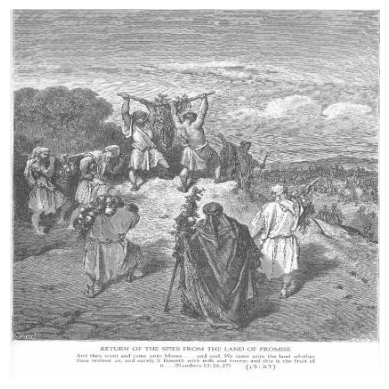

Output image


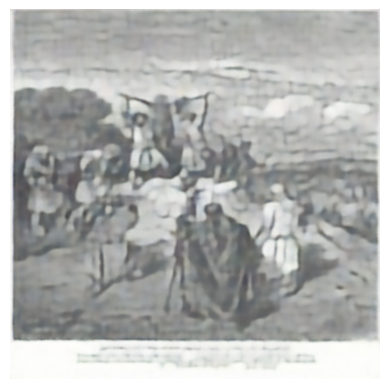

In [191]:
# Evaluate model on a given filename with false label

mismatched_dataset = WikiArtDataset(mismatcheddir, device)

img, label = mismatched_dataset.get_image_by_filename("gustave-dore_the-spies-return-from-the-promised-land_jpg.rf.0d2277ec8efe5f55abbd27161053310e.jpg")

input_img = F.to_pil_image(img)
print("Input image")
plt.imshow(input_img)
plt.axis('off')
plt.show()

model = AutoEncoder().to(device)
model.load_state_dict(torch.load(modelfile, map_location=device, weights_only=True))

loader = DataLoader(mismatched_dataset, batch_size=1)

model.eval()

for batch_id, batch in enumerate((loader)):
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            output = model(X, y)

output = output.squeeze(0) # remove batch size dimension
output_img = F.to_pil_image(output)
plt.axis('off')
print("Output image")
plt.imshow(output_img)

